# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`:**  Tanu Adhikari
**`Roll Number`:** U20230115 
**`GitHub Branch`:** tanu_U20230115 

# Imports and Setup

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from rlcmab_sampler import sampler


# Load Datasets

In [12]:
# Load training and test datasets
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

# Separate input features and target variable
X_train_full = train_users.drop(columns=['label', 'user_id'])
y_train_full = train_users['label']

# Test set has no labels
X_test = test_users.drop(columns=['user_id'])

## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [13]:
# Fill missing values in 'age' using median
X_train_full['age'].fillna(X_train_full['age'].median(), inplace=True)
X_test['age'].fillna(X_test['age'].median(), inplace=True)

# Store label encoders for categorical columns
label_encoders = {}
categorical_cols = ['browser_version', 'region_code']

# Encode categorical features
for col in categorical_cols:
    le = LabelEncoder()
    
    # Fit encoder on training data
    X_train_full[col] = le.fit_transform(X_train_full[col].astype(str))
    
    # Handle unseen categories in test data
    encoded_test = []
    for val in X_test[col].astype(str):
        if val in le.classes_:
            encoded_test.append(le.transform([val])[0])
        else:
            # Assign unseen category a default value
            encoded_test.append(-1)
    
    X_test[col] = encoded_test
    label_encoders[col] = le

C:\Users\csadh\AppData\Local\Temp\ipykernel_25096\1162909737.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_full['age'].fillna(X_train_full['age'].median(), inplace=True)
C:\Users\csadh\AppData\Local\Temp\ipykernel_25096\1162909737.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [14]:
# Convert boolean 'subscriber' column to integer
X_train_full['subscriber'] = X_train_full['subscriber'].astype(int)
X_test['subscriber'] = X_test['subscriber'].astype(int)

# Encode target labels (user categories)
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train_full)

## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.


In [15]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_train_encoded
)

# Print dataset shapes
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTarget classes: {le_target.classes_}")

Training set shape: (1600, 31)
Validation set shape: (400, 31)
Test set shape: (2000, 31)

Target classes: ['user_1' 'user_2' 'user_3']


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize Gradient Boosting Classifier with tuned hyperparameters
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42,
    verbose=1
)

# Train the model
print("Training Gradient Boosting Classifier...")
gb_clf.fit(X_train, y_train)

Training Gradient Boosting Classifier...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9499           0.1341            4.73s
         2           0.8395           0.1091            5.78s
         3           0.7528           0.1026            5.83s
         4           0.6788           0.0741            5.77s
         5           0.6157           0.0561            5.81s
         6           0.5615           0.0420            5.95s
         7           0.5225           0.0689            5.83s
         8           0.4761           0.0203            6.30s
         9           0.4451           0.0359            6.11s
        10           0.4160           0.0268            5.90s
        20           0.2493          -0.0370            5.58s
        30           0.1712          -0.0295            5.06s
        40           0.1292          -0.0134            4.27s
        50           0.0981          -0.0283            3.64s
        60           0.0773 

GradientBoostingClassifier(max_depth=5, min_samples_leaf=10,
                           min_samples_split=20, random_state=42, subsample=0.8,
                           verbose=1)

In [17]:
# Predict on validation set
y_val_pred = gb_clf.predict(X_val)

# Compute validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("=" * 60)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("=" * 60)

# Detailed performance metrics
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le_target.classes_))

print("\nConfusion Matrix (Validation Set):")
print(confusion_matrix(y_val, y_val_pred))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gb_clf.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Validation Accuracy: 0.9075

Classification Report (Validation Set):
              precision    recall  f1-score   support

      user_1       0.90      0.86      0.88       142
      user_2       0.99      0.88      0.93       142
      user_3       0.84      1.00      0.91       116

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400


Confusion Matrix (Validation Set):
[[122   1  19]
 [ 14 125   3]
 [  0   0 116]]

Top 10 Most Important Features:
                  feature  importance
4        session_duration    0.393034
29            region_code    0.333421
0                     age    0.055386
15  preferred_price_range    0.020425
5         content_variety    0.017644
13           time_on_site    0.014131
12        scroll_activity    0.011889
25        browser_version    0.010574
14      interaction_count    0.009706
20       churn_risk_score    0.009429


In [18]:
# Predict categories for test users
y_test_pred = gb_clf.predict(X_test)
test_users['predicted_user_category'] = le_target.inverse_transform(y_test_pred)

print("Test predictions completed!")
print("\nPredicted distribution:")
print(test_users['predicted_user_category'].value_counts())

print("\nFirst 5 test predictions:")
print(test_users[['user_id', 'predicted_user_category']].head())

Test predictions completed!

Predicted distribution:
predicted_user_category
user_2    712
user_1    674
user_3    614
Name: count, dtype: int64

First 5 test predictions:
  user_id predicted_user_category
0   U4058                  user_2
1   U1118                  user_1
2   U6555                  user_1
3   U9170                  user_1
4   U3348                  user_1


In [19]:
# Reload original test data to ensure correct user IDs
test_users_original = pd.read_csv("data/test_users.csv")

# Convert encoded predictions back to labels
predicted_labels = le_target.inverse_transform(y_test_pred)

# Save final predictions
output_df = pd.DataFrame({
    'user_id': test_users_original['user_id'],
    'predicted_user_category': predicted_labels
})

output_df.to_csv('test_predictions.csv', index=False)

print("✓ Predictions saved to 'test_predictions.csv'")
print("=" * 60)
print("Prediction Complete!")
print("=" * 60)

✓ Predictions saved to 'test_predictions.csv'
Prediction Complete!


# `Contextual Bandit`

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

In [20]:
# Initialize the reward sampler with your roll number
ROLL_NUMBER = 115
reward_sampler = sampler(ROLL_NUMBER)

# Arm mapping as per assignment
ARM_MAPPING = {
    'User1': {'Entertainment': 0, 'Education': 1, 'Tech': 2, 'Crime': 3},
    'User2': {'Entertainment': 4, 'Education': 5, 'Tech': 6, 'Crime': 7},
    'User3': {'Entertainment': 8, 'Education': 9, 'Tech': 10, 'Crime': 11}
}

CONTEXTS = ['User1', 'User2', 'User3']
CATEGORIES = ['Entertainment', 'Education', 'Tech', 'Crime']

## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


In [21]:
class EpsilonGreedy:
    def __init__(self, epsilon, context):
        self.epsilon = epsilon
        self.context = context
        self.n_arms = len(CATEGORIES)
        self.counts = np.zeros(self.n_arms)
        self.values = np.zeros(self.n_arms)
        self.rewards_history = []
        
    def select_arm(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        else:
            return np.argmax(self.values)
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward
        self.rewards_history.append(reward)
    
    def get_arm_index(self, category_idx):
        category = CATEGORIES[category_idx]
        return ARM_MAPPING[self.context][category]


def run_epsilon_greedy(epsilon_values, T=10000):
    results = {}
    
    for epsilon in epsilon_values:
        print(epsilon)
        context_models = {}
        context_rewards = {context: [] for context in CONTEXTS}
        
        for context in CONTEXTS:
            model = EpsilonGreedy(epsilon, context)
            for t in range(T):
                arm = model.select_arm()
                j = model.get_arm_index(arm)
                reward = reward_sampler.sample(j)
                model.update(arm, reward)
            context_models[context] = model
            context_rewards[context] = model.rewards_history
        
        results[epsilon] = {
            'models': context_models, 
            'rewards': context_rewards
        }
    
    return results

## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [22]:
class UCB:
    def __init__(self, c, context):
        self.c = c
        self.context = context
        self.n_arms = len(CATEGORIES)
        self.counts = np.zeros(self.n_arms)
        self.values = np.zeros(self.n_arms)
        self.rewards_history = []
        self.t = 0
        
    def select_arm(self):
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(
            np.log(self.t + 1) / self.counts
        )
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.t += 1
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward
        self.rewards_history.append(reward)
    
    def get_arm_index(self, category_idx):
        category = CATEGORIES[category_idx]
        return ARM_MAPPING[self.context][category]


def run_ucb(c_values, T=10000):
    results = {}
    
    for c in c_values:
        print(c)
        context_models = {}
        context_rewards = {context: [] for context in CONTEXTS}
        
        for context in CONTEXTS:
            model = UCB(c, context)
            for t in range(T):
                arm = model.select_arm()
                j = model.get_arm_index(arm)
                reward = reward_sampler.sample(j)
                model.update(arm, reward)
            context_models[context] = model
            context_rewards[context] = model.rewards_history
        
        results[c] = {
            'models': context_models, 
            'rewards': context_rewards
        }
    
    return results

## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


In [23]:
class SoftMax:
    def __init__(self, tau, context):
        self.tau = tau
        self.context = context
        self.n_arms = len(CATEGORIES)
        self.counts = np.zeros(self.n_arms)
        self.values = np.zeros(self.n_arms)
        self.rewards_history = []
        
    def select_arm(self):
        z = self.values / self.tau
        z = z - np.max(z)
        probabilities = np.exp(z) / np.sum(np.exp(z))
        return np.random.choice(self.n_arms, p=probabilities)
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward
        self.rewards_history.append(reward)
    
    def get_arm_index(self, category_idx):
        category = CATEGORIES[category_idx]
        return ARM_MAPPING[self.context][category]


def run_softmax(tau=1.0, T=10000):
    print(tau)
    context_models = {}
    context_rewards = {context: [] for context in CONTEXTS}
    
    for context in CONTEXTS:
        model = SoftMax(tau, context)
        for t in range(T):
            arm = model.select_arm()
            j = model.get_arm_index(arm)
            reward = reward_sampler.sample(j)
            model.update(arm, reward)
        context_models[context] = model
        context_rewards[context] = model.rewards_history
    
    return {
        'models': context_models, 
        'rewards': context_rewards
    }

In [24]:
# Epsilon-Greedy with different epsilon values
epsilon_values = [0.01, 0.1, 0.3]
epsilon_greedy_results = run_epsilon_greedy(epsilon_values, T=10000)

# UCB with different c values
c_values = [0.5, 1.0, 2.0]
ucb_results = run_ucb(c_values, T=10000)

# SoftMax with tau=1
softmax_results = run_softmax(tau=1.0, T=10000)

print("Training completed")

0.01
0.1
0.3
0.5
1.0
2.0
1.0
Training completed


In [25]:
# Load news articles dataset
news_articles = pd.read_csv("data/news_articles.csv")

print("News articles loaded")

News articles loaded


In [29]:
def recommend_article(user_features, classifier, bandit_model, news_articles):
    user_context = classifier.predict([user_features])[0]
    best_arm = np.argmax(bandit_model.values)
    news_category = CATEGORIES[best_arm]
    
    category_articles = news_articles[
        news_articles['category'] == news_category
    ]
    
    if len(category_articles) > 0:
        article = category_articles.sample(n=1).iloc[0]
    else:
        article = news_articles.sample(n=1).iloc[0]
    
    return {
        'user_context': user_context,
        'news_category': news_category,
        'article': article.to_dict()
    }

In [33]:
# Create mapping from numeric labels to user context strings
label_to_context = {0: 'User1', 1: 'User2', 2: 'User3'}

# Select best models
best_epsilon = 0.1
best_models = epsilon_greedy_results[best_epsilon]['models']

# Test on first few users from test set
for i in range(min(5, len(X_test))):
    user_features = X_test.iloc[i:i+1]
    predicted_label = gb_clf.predict(user_features)[0]
    predicted_context = label_to_context[predicted_label]
    
    bandit_model = best_models[predicted_context]
    recommendation = recommend_article(
        user_features.values[0], 
        gb_clf, 
        bandit_model, 
        news_articles
    )
    
    print(recommendation['user_context'])
    print(recommendation['news_category'])
    print(recommendation['article']['headline'])

1
Entertainment
Male-Run Domestic Violence Group Apologizes For Telling ESPN Ray Rice Deserves Second Chance
0
Tech
The Huffington Post Is Hiring A Tech Reporter
0
Tech
Jimmy Fallon And Martin Short Give Classic Christmas Song A Scary Trump Twist
0
Tech
Jaden Smith Looks Surprised As Hell With The Kardashians
0
Tech
The Surprising Reason Why We Break Promises


d:\OneDrive\Documents\Agriculture\.conda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
d:\OneDrive\Documents\Agriculture\.conda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
d:\OneDrive\Documents\Agriculture\.conda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
d:\OneDrive\Documents\Agriculture\.conda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
d:\OneDrive\Documents\Agriculture\.conda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not

In [34]:
def calculate_cumulative_average_reward(rewards):
    cumulative_sum = np.cumsum(rewards)
    timesteps = np.arange(1, len(rewards) + 1)
    return cumulative_sum / timesteps


def plot_average_reward_vs_time(results, algorithm_name):
    plt.figure(figsize=(12, 6))
    
    for context in CONTEXTS:
        rewards = results['rewards'][context]
        avg_rewards = calculate_cumulative_average_reward(rewards)
        plt.plot(avg_rewards, label=context, linewidth=2)
    
    plt.xlabel('Time Steps')
    plt.ylabel('Average Reward')
    plt.title(f'{algorithm_name}: Average Reward vs Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_hyperparameter_comparison(results_dict, param_name, algorithm_name):
    plt.figure(figsize=(14, 6))
    n_params = len(results_dict)
    
    for idx, (param_value, results) in enumerate(results_dict.items()):
        plt.subplot(1, n_params, idx + 1)
        
        for context in CONTEXTS:
            rewards = results['rewards'][context]
            avg_rewards = calculate_cumulative_average_reward(rewards)
            plt.plot(avg_rewards, label=context, linewidth=2)
        
        plt.xlabel('Time Steps')
        plt.ylabel('Average Reward')
        plt.title(f'{param_name} = {param_value}')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.suptitle(
        f'{algorithm_name}: Hyperparameter Comparison', 
        fontsize=14, 
        y=1.02
    )
    plt.tight_layout()
    plt.show()


def print_expected_reward_distribution(results, algorithm_name, param_value=None):
    if param_value is not None:
        print(algorithm_name)
        print(param_value)
    else:
        print(algorithm_name)
    
    for context in CONTEXTS:
        model = results['models'][context]
        print(context)
        for i, category in enumerate(CATEGORIES):
            print(f"{category}: {model.values[i]:.4f}")

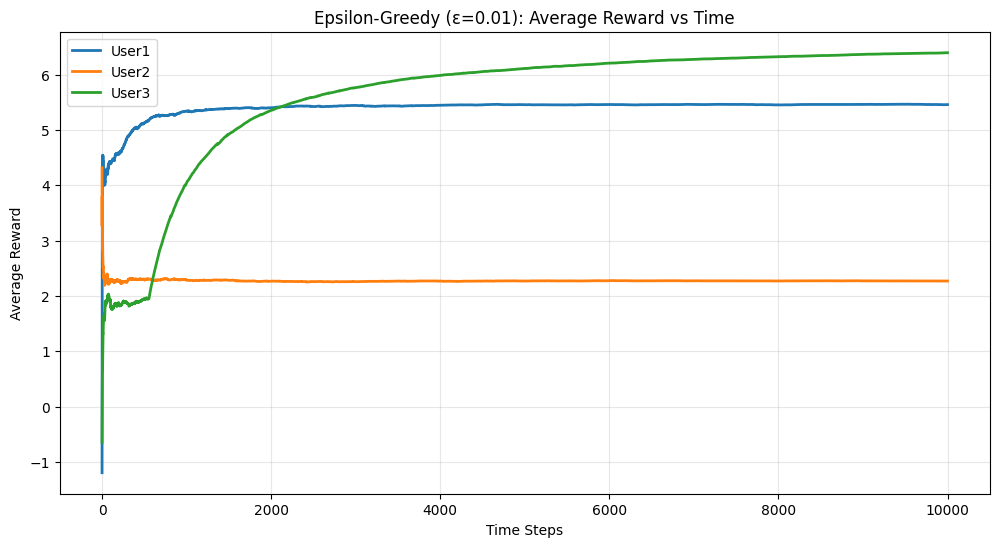

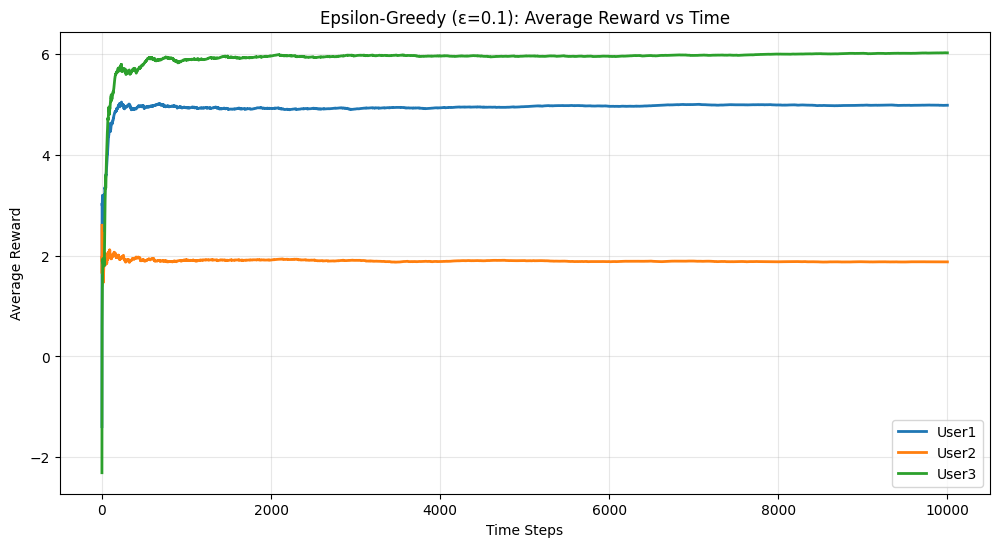

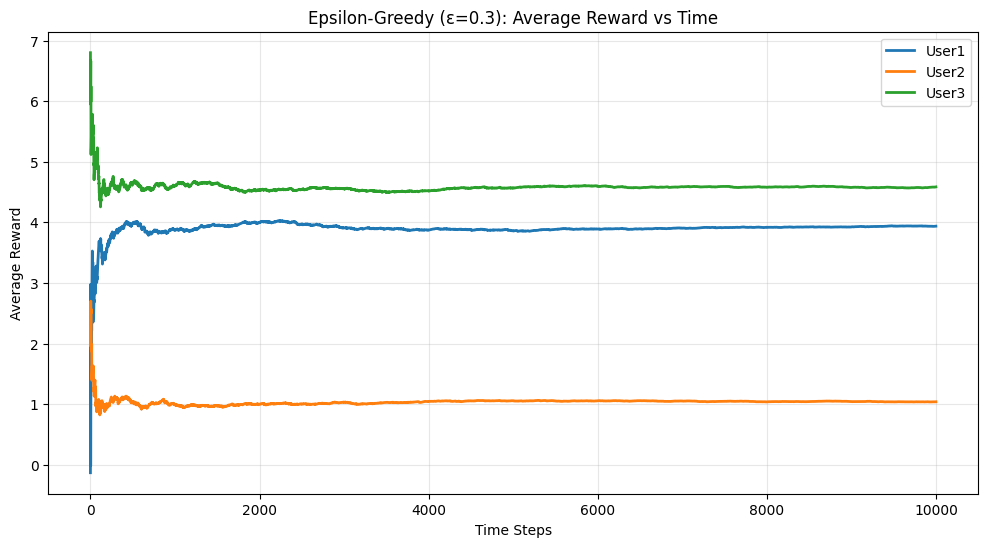

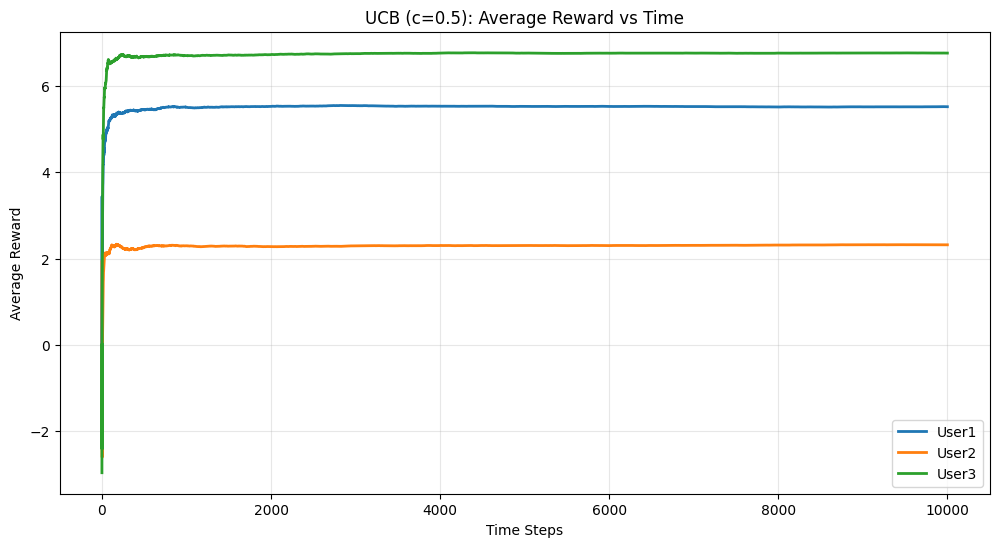

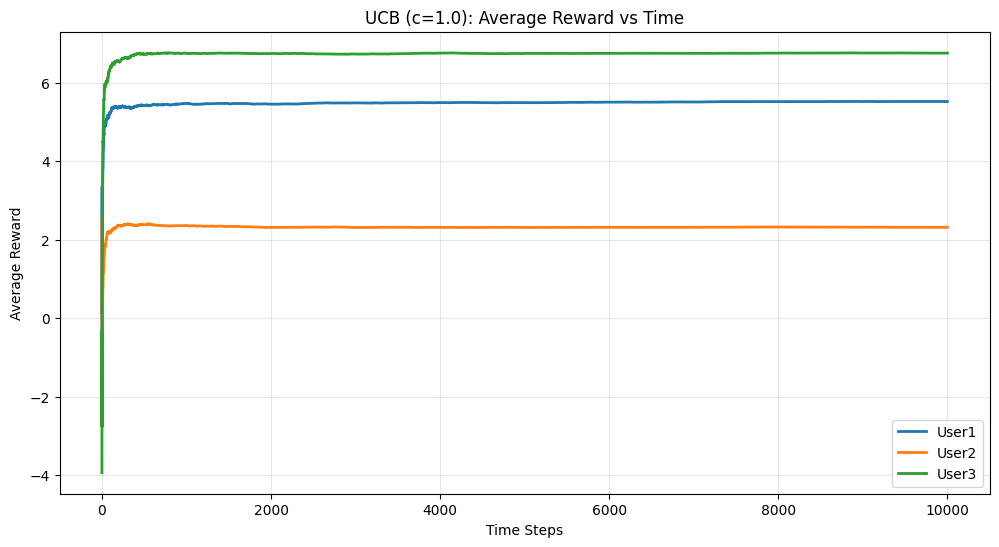

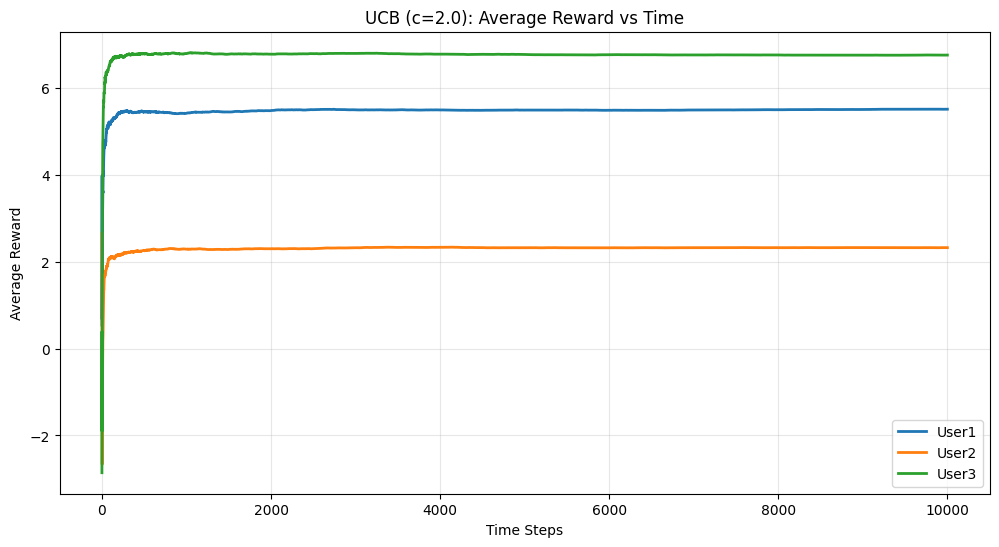

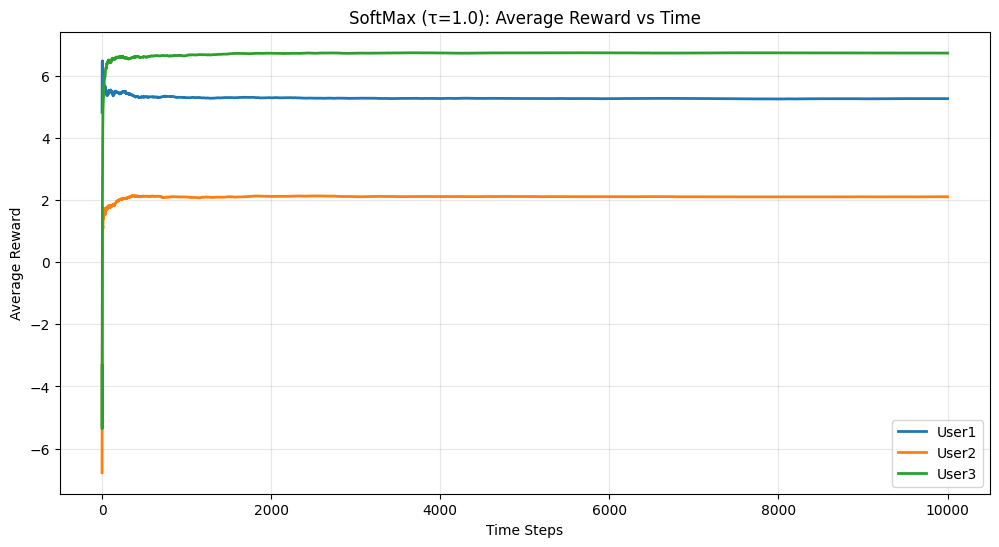

In [35]:
for epsilon, results in epsilon_greedy_results.items():
    plot_average_reward_vs_time(results, f'Epsilon-Greedy (ε={epsilon})')

for c, results in ucb_results.items():
    plot_average_reward_vs_time(results, f'UCB (c={c})')

plot_average_reward_vs_time(softmax_results, 'SoftMax (τ=1.0)')

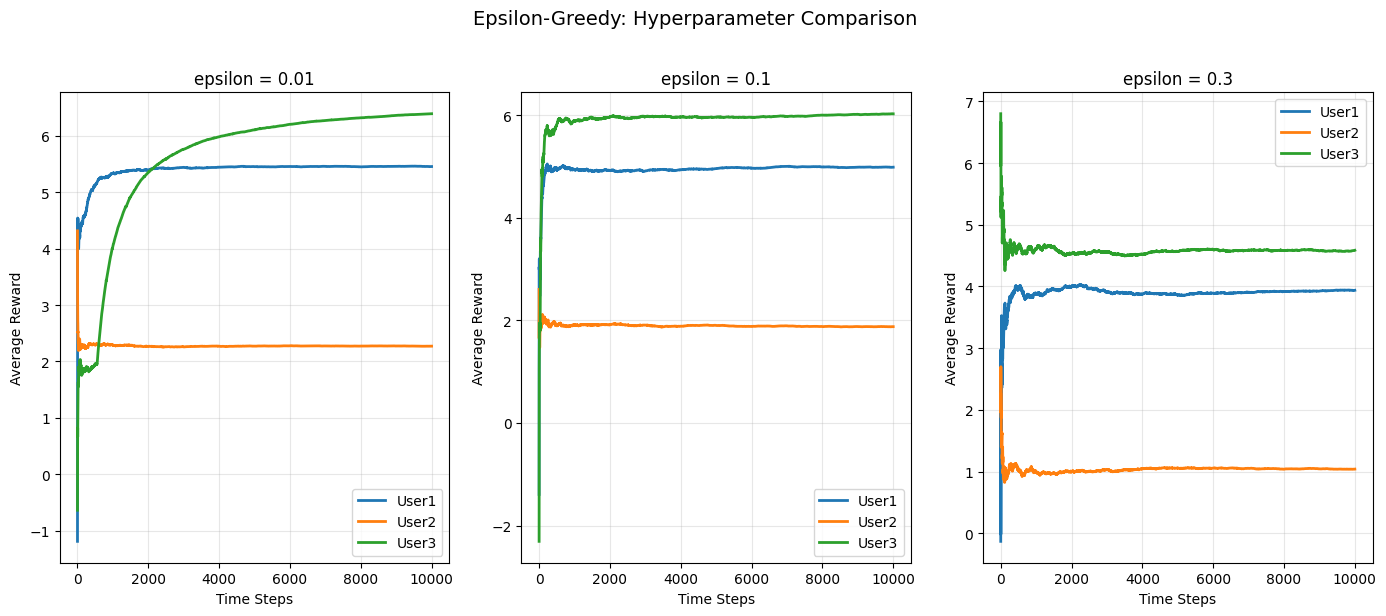

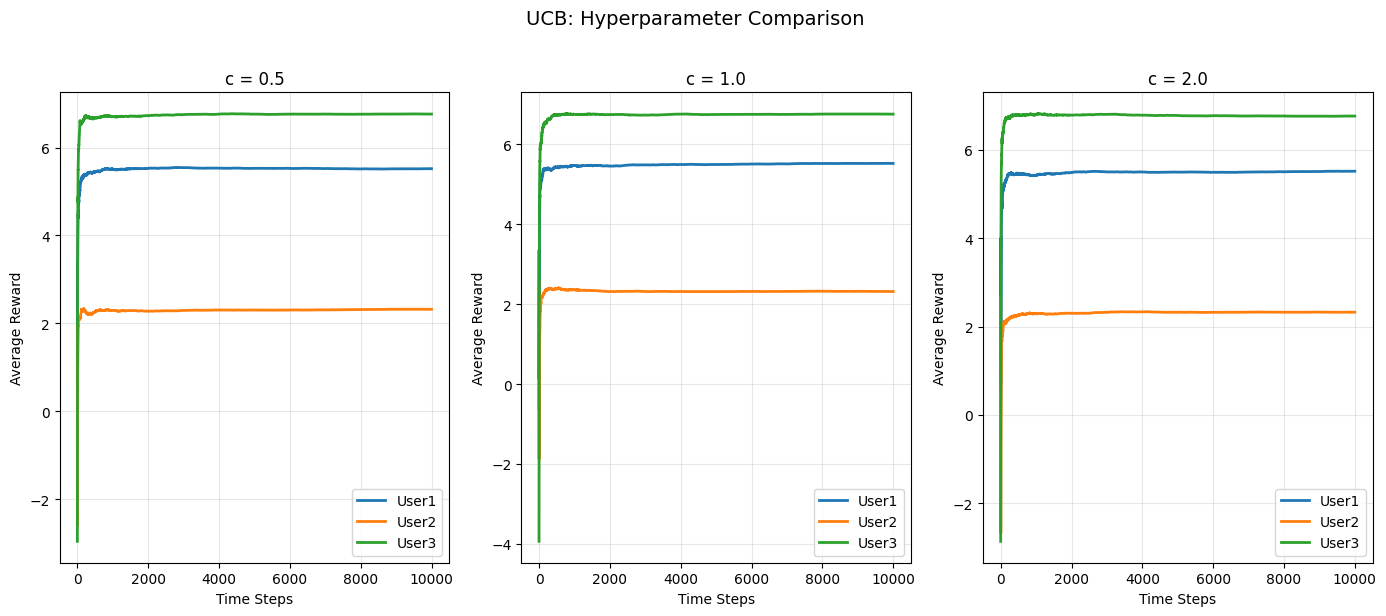

In [36]:
plot_hyperparameter_comparison(
    epsilon_greedy_results, 
    'epsilon', 
    'Epsilon-Greedy'
)

plot_hyperparameter_comparison(ucb_results, 'c', 'UCB')

In [38]:
for epsilon, results in epsilon_greedy_results.items():
    print_expected_reward_distribution(results, 'Epsilon-Greedy', epsilon)

for c, results in ucb_results.items():
    print_expected_reward_distribution(results, 'UCB', c)

print_expected_reward_distribution(softmax_results, 'SoftMax', 1.0)

Epsilon-Greedy
0.01
User1
Entertainment: -0.1578
Education: 4.6136
Tech: 5.5402
Crime: -8.8876
User2
Entertainment: 2.3277
Education: -4.0413
Tech: 0.2482
Crime: -6.4855
User3
Entertainment: -3.1557
Education: 2.0243
Tech: -7.6785
Crime: 6.7357
Epsilon-Greedy
0.1
User1
Entertainment: -0.2590
Education: 4.8789
Tech: 5.5102
Crime: -9.1340
User2
Entertainment: 2.3363
Education: -4.3138
Tech: 0.1628
Crime: -6.2434
User3
Entertainment: -3.2320
Education: 1.8900
Tech: -7.7234
Crime: 6.7488
Epsilon-Greedy
0.3
User1
Entertainment: -0.3382
Education: 4.7250
Tech: 5.5518
Crime: -9.0616
User2
Entertainment: 2.3288
Education: -4.2440
Tech: 0.0835
Crime: -6.3371
User3
Entertainment: -3.2252
Education: 1.9714
Tech: -7.7082
Crime: 6.7635
UCB
0.5
User1
Entertainment: -0.7902
Education: 4.0201
Tech: 5.5231
Crime: -10.5684
User2
Entertainment: 2.3220
Education: -3.9376
Tech: -1.5248
Crime: -6.8902
User3
Entertainment: -2.9624
Education: 3.0159
Tech: -7.2977
Crime: 6.7667
UCB
1.0
User1
Entertainment: -0.

In [39]:
for epsilon, results in epsilon_greedy_results.items():
    avg_final = np.mean([
        np.mean(results['rewards'][ctx][-1000:]) 
        for ctx in CONTEXTS
    ])
    print(f"Epsilon-Greedy {epsilon}: {avg_final:.4f}")

for c, results in ucb_results.items():
    avg_final = np.mean([
        np.mean(results['rewards'][ctx][-1000:]) 
        for ctx in CONTEXTS
    ])
    print(f"UCB {c}: {avg_final:.4f}")

avg_final = np.mean([
    np.mean(softmax_results['rewards'][ctx][-1000:]) 
    for ctx in CONTEXTS
])
print(f"SoftMax 1.0: {avg_final:.4f}")

Epsilon-Greedy 0.01: 4.7758
Epsilon-Greedy 0.1: 4.3232
Epsilon-Greedy 0.3: 3.2448
UCB 0.5: 4.8734
UCB 1.0: 4.8435
UCB 2.0: 4.8887
SoftMax 1.0: 4.7069
